In [1]:
import tensorflow as tf
import numpy as np
import gpflow

from robust_gp import DSM_GPR
from diffusion_matrix import Shrinkage_Diffusion_matrix, Identity_Diffusion_matrix

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

(0.0, 20.0)

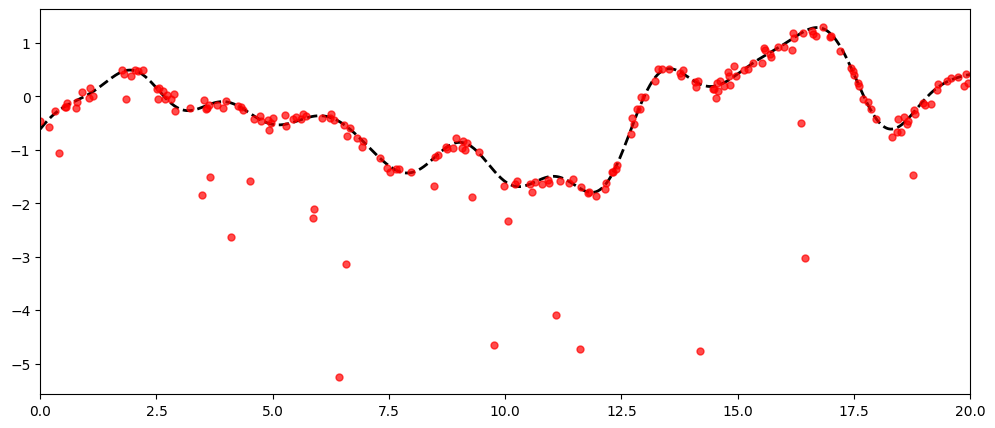

In [3]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

n_points = 1000
sigma_n = 0.1
percent = 0.2
percent_miss = 0.1

kernel=gpflow.kernels.SquaredExponential()

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_obs, 1), int(percent_miss * n_obs), replace=False)

y_obs[i_mis] = y_obs[i_mis] - np.abs(np.random.normal(scale=2, size=len(i_mis))).reshape(len(i_mis),1)

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

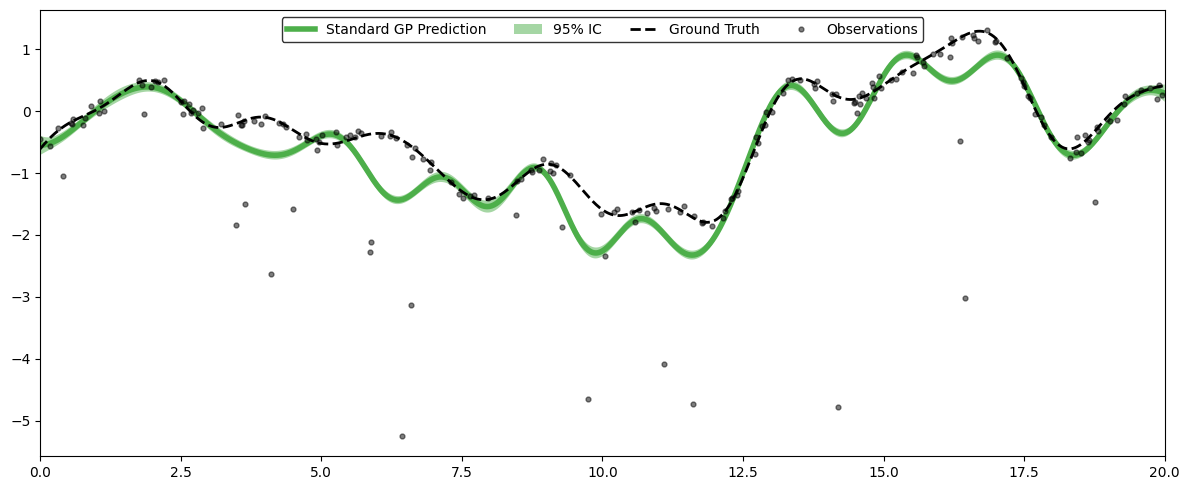

In [4]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

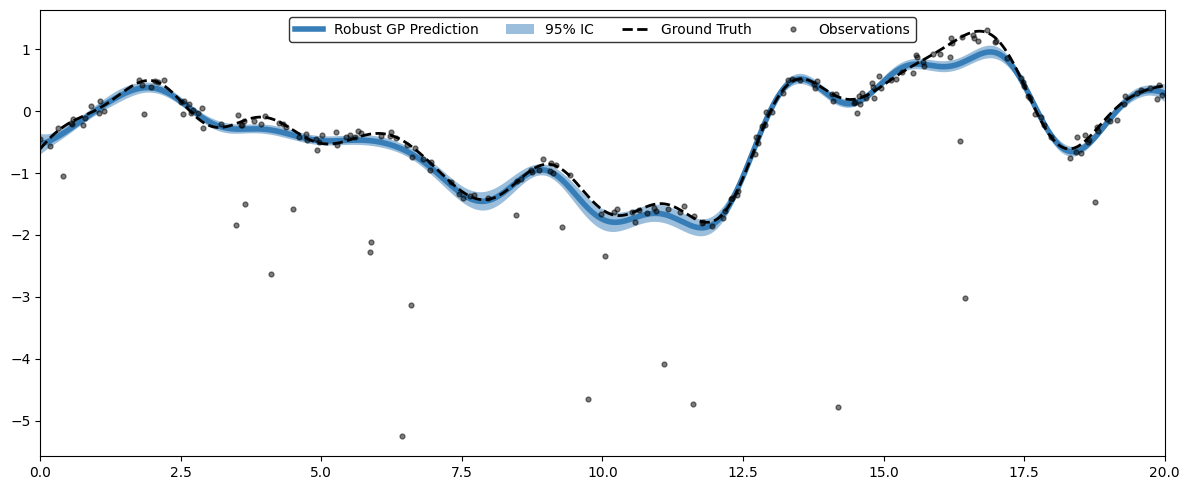

In [5]:
# plot estimation, obs and real data
dsm_gp = DSM_GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    diffusion_matrix = Shrinkage_Diffusion_matrix(),
    noise_variance=sigma_n**2 
)

f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)
plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

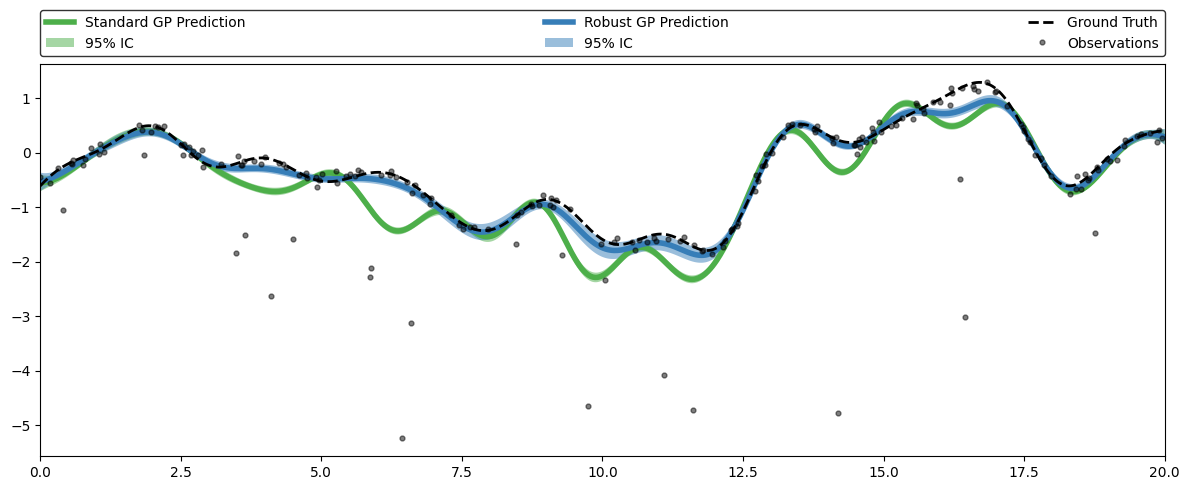

In [6]:
plt.plot(x[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')

plt.tight_layout()

# Training

In [7]:
def run_adam(model, iterations, minibatch_size=100):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure()
    optimizer = tf.optimizers.legacy.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf


In [8]:
maxiter = 20000
lengthscale_0 = 1
variance_0 = 1
variance_n_0 =1

╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ DSM_GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.52655 │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ DSM_GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.60445 │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ DSM_GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.01    │
╘═════════════════════════════╧═══════════╧══════════════════╧══

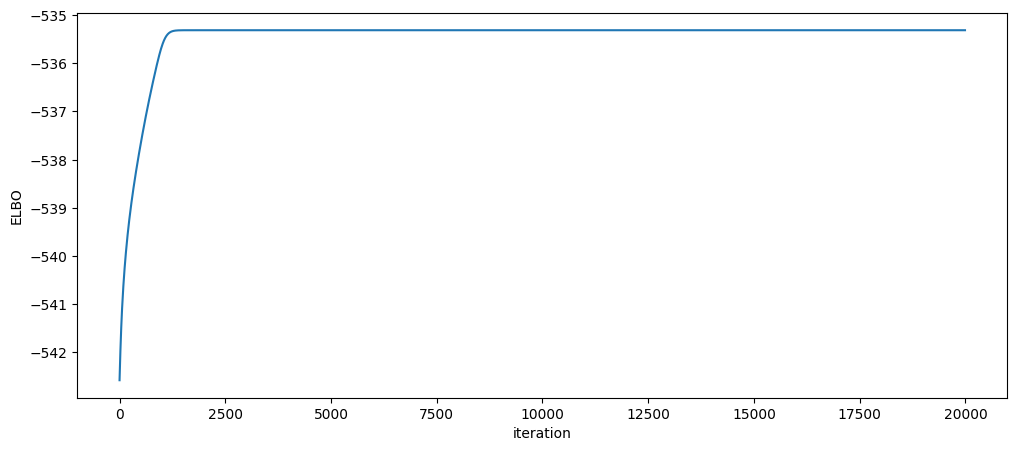

In [9]:
# plot estimation, obs and real data
dsm_gp = DSM_GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale_0, variance=variance_0),
    diffusion_matrix = Shrinkage_Diffusion_matrix(),
    noise_variance=sigma_n**2
)

gpflow.set_trainable(dsm_gp.likelihood.variance, False)

logf = run_adam(dsm_gp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")
gpflow.utilities.print_summary(dsm_gp)

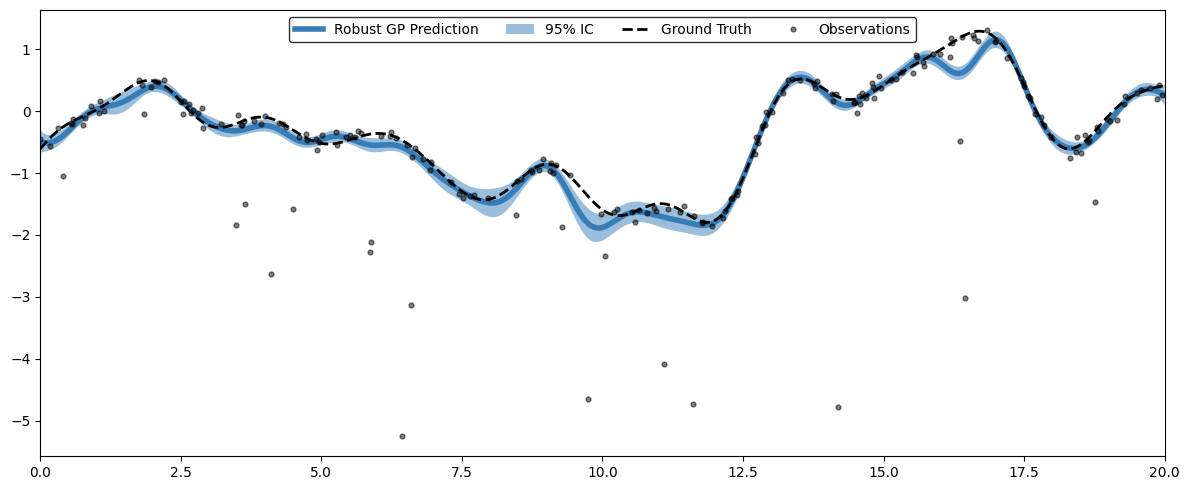

In [10]:
f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)
plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.51701 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.03407 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.01    │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

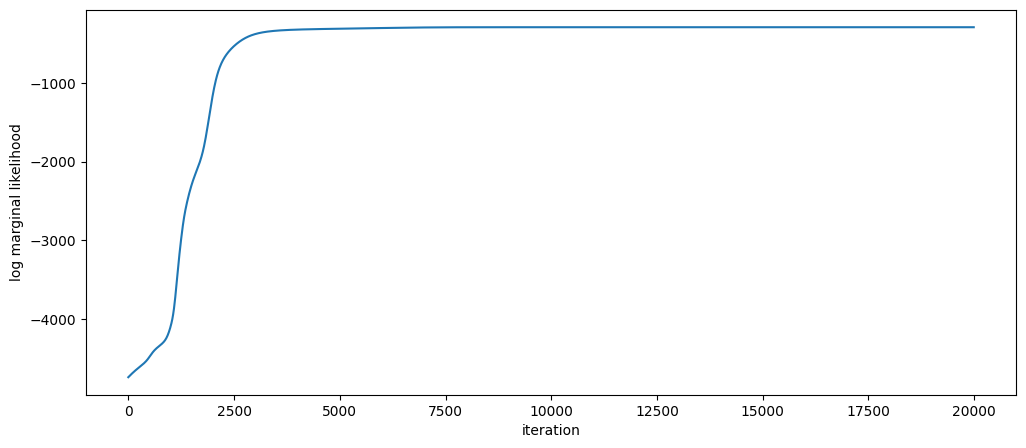

In [11]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale_0, variance=variance_0),
    noise_variance=sigma_n**2
)

gpflow.set_trainable(standard_gp.likelihood.variance, False)

logf = run_adam(standard_gp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("log marginal likelihood")
gpflow.utilities.print_summary(standard_gp)

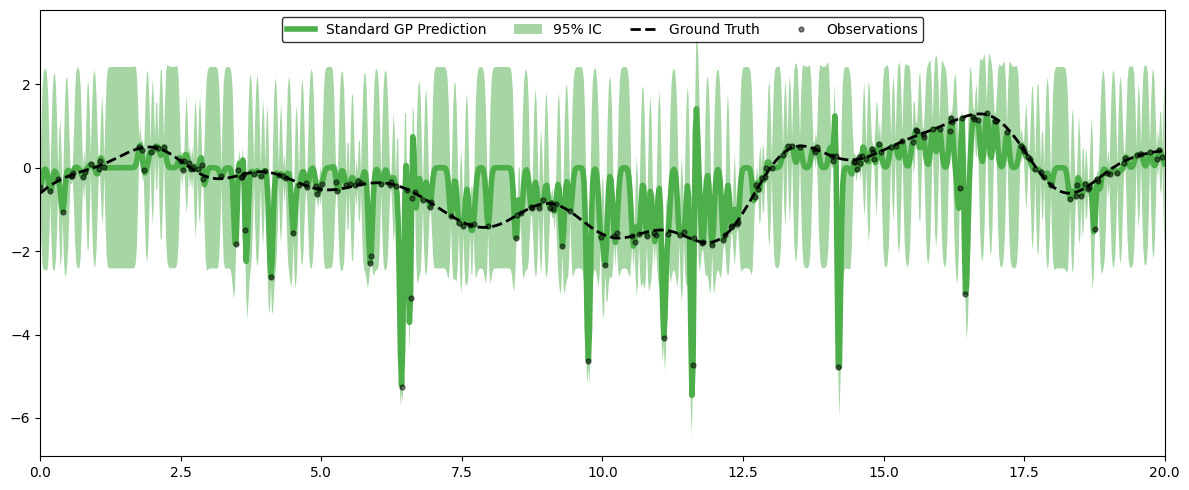

In [12]:
f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()